In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/Users/massil/repos/newsvendor_tester


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from environment import *
from algorithms.ddm import DDM_algorithm
from algorithms.maxcosd_volume_constrained import MaxCOSD_Volume_Constrained_algorithm
from simulator import Simulator

In [16]:
m5_demands = pd.read_csv("m5_experiments/m5_demands.csv")
samples_list = m5_demands.sample_id.unique()
nb_samples = len(samples_list)
horizon = m5_demands.period.max()
nb_products = len(m5_demands.product_id.unique())

costs_df = pd.read_csv("m5_experiments/m5_costs.csv")
holding_costs = costs_df["holding_cost"].values
penalty_costs = costs_df["penalty_cost"].values

envs = []
for sample_id in samples_list :
    demands = (m5_demands
        .loc[m5_demands.sample_id == sample_id, "quantity"]
        .values
        .reshape(horizon+1,nb_products)
    )
    envs.append(Environment_NonPerishable_Newsvendor(demands, holding_costs, penalty_costs))

Optimal stationary base-stock policy in hindsight

In [69]:
quantile_sum = 0
for i in range(nb_products) :
    quantile = np.quantile(envs[9].demands[1:,i], penalty_costs[i]/(holding_costs[i]+penalty_costs[i]))
    quantile_sum += quantile
    print("Product {}: critical ratio {}, critical quantile {}".format(i,
        penalty_costs[i]/(holding_costs[i]+penalty_costs[i]),
        quantile
    ))
print("Sum of critical quantiles: {}".format(quantile_sum))

Product 0: critical ratio 0.9950248757188375, critical quantile 100.20895541467212
Product 1: critical ratio 0.9950248754291985, critical quantile 87.20895484466268
Product 2: critical ratio 0.995024875331043, critical quantile 34.41790930298521
Product 3: critical ratio 0.995024875331043, critical quantile 80.0
Product 4: critical ratio 0.9950248753173447, critical quantile 85.2089546245345
Product 5: critical ratio 0.9950248752148418, critical quantile 62.4179088456176
Product 6: critical ratio 0.9950248754292028, critical quantile 97.2089548446711
Product 7: critical ratio 0.9950248753307123, critical quantile 32.0
Product 8: critical ratio 0.9950248754292028, critical quantile 31.0
Product 9: critical ratio 0.9950248757188375, critical quantile 17.0
Sum of critical quantiles: 626.6716378771432


In [39]:
volumes = np.ones(nb_products)
total_volume = 1000
diameter = total_volume*np.sqrt(1/(np.sort(volumes)[0]**2)+1/(np.sort(volumes)[1]**2))
G = np.sqrt(nb_products)*np.max(np.maximum(holding_costs,penalty_costs))

In [40]:
initial_decision = np.zeros(nb_products)
list_gamma = [10**exponent for exponent in np.linspace(-5,1,9*7+1)]

algs = [ DDM_algorithm(initial_decision,volumes,total_volume, gamma_value,G,holding_costs,penalty_costs) for gamma_value in list_gamma]
algs += [ MaxCOSD_Volume_Constrained_algorithm(initial_decision,volumes, total_volume, gamma_value) for gamma_value in list_gamma] 

nb_algs = len(algs)

In [41]:
horizons = np.linspace(10,horizon,100).astype(int)

sim = Simulator(envs, nb_products, nb_samples, horizons, algs,
   lambda optimum : np.sum(volumes*optimum)<=total_volume, holding_costs, penalty_costs)
cum_losses = sim.run()

100%|██████████| 10/10 [04:12<00:00, 25.28s/it]


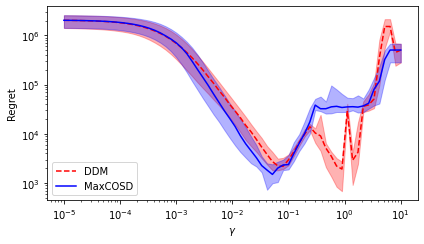

In [70]:
ddm_median_regret = np.array([np.median(cum_losses[:,gamma_index,-1]-cum_losses[:,0,-1]) for gamma_index in range(1,len(list_gamma)+1)])
ddm_q20_regret = np.array([np.quantile(cum_losses[:,gamma_index,-1]-cum_losses[:,0,-1],q=0.2) for gamma_index in range(1,len(list_gamma)+1)])
ddm_q80_regret = np.array([np.quantile(cum_losses[:,gamma_index,-1]-cum_losses[:,0,-1],q=0.8) for gamma_index in range(1,len(list_gamma)+1)])

cosd_median_cum_losses = np.array([np.median(cum_losses[:,gamma_index,-1]-cum_losses[:,0,-1]) for gamma_index in range(1*len(list_gamma)+1,2*len(list_gamma)+1)])
cosd_q20_regret = np.array([np.quantile(cum_losses[:,gamma_index,-1]-cum_losses[:,0,-1],q=0.2) for gamma_index in range(1*len(list_gamma)+1,2*len(list_gamma)+1)])
cosd_q80_regret = np.array([np.quantile(cum_losses[:,gamma_index,-1]-cum_losses[:,0,-1],q=0.8) for gamma_index in range(1*len(list_gamma)+1,2*len(list_gamma)+1)])

plt.figure(figsize=(6,3.5))
#plt.axhline(np.mean(cum_losses[:,0,-1]), color="black", linestyle="--", label="Comparator")

plt.loglog(list_gamma,ddm_median_regret, color="red", label="DDM",linestyle="--")
plt.fill_between(list_gamma, ddm_q20_regret, ddm_q80_regret, color="red", alpha=0.3)

plt.loglog(list_gamma,cosd_median_cum_losses, color="blue", label="MaxCOSD")
plt.fill_between(list_gamma, cosd_q20_regret, cosd_q80_regret, color="blue", alpha=0.3)

#plt.axvline(gamma,linestyle="--",color="black")
#plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel(r"$\gamma$")
plt.ylabel("Regret")
plt.legend(loc="lower left")

plt.tight_layout()
plt.savefig("images/m5_gamma_1.png", dpi=300)
plt.show()

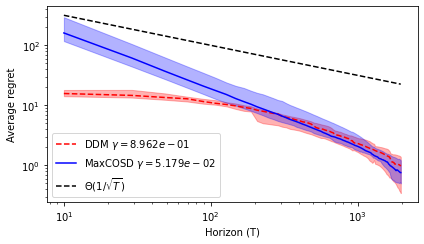

In [74]:
ddm_gamma_index_opt = np.argmin(np.mean(cum_losses[:,1:len(list_gamma)+1,-1],axis=0))+1
cosd_gamma_index_opt = np.argmin(np.mean(cum_losses[:,1*len(list_gamma)+1:2*len(list_gamma)+1,-1],axis=0))+1*len(list_gamma)+1
colors = {ddm_gamma_index_opt:"red", cosd_gamma_index_opt:"blue"}
linestyles = {ddm_gamma_index_opt:"--", cosd_gamma_index_opt:"-"}

plt.figure(figsize=(6,3.5))

for i in [ddm_gamma_index_opt, cosd_gamma_index_opt] :
    y = np.median(cum_losses[:,i,:]-cum_losses[:,0,:],axis=0)
    y_q20 = np.quantile(cum_losses[:,i,:]-cum_losses[:,0,:],q=0.2, axis=0)
    y_q80 = np.quantile(cum_losses[:,i,:]-cum_losses[:,0,:],q=0.8, axis=0)
    plt.loglog(horizons, y/horizons,label=algs[i-1], color=colors[i], linestyle=linestyles[i])
    plt.fill_between(horizons, y_q20/horizons,y_q80/horizons, color=colors[i], alpha=0.3)
#plt.axhline(0,color="k")
#plt.plot(horizons,np.sqrt(horizons)*D/2*np.sqrt(2/np.pi),"--",color="k",label="theoretical equivalent")
#plt.plot(horizons,(1/(2*gamma)+gamma+1)*G*diameter/np.sqrt(horizons),"x",color="k",label="theoretical upper bound")
plt.loglog(horizons,10**3/np.sqrt(horizons),"--",color="k",label=r"$\Theta(1/\sqrt{T})$")

plt.ylabel("Average regret")
plt.xlabel("Horizon (T)")
plt.legend(loc="lower left")
#plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.tight_layout()
plt.savefig("images/m5_avgregret_1.png", dpi=300)
plt.show()